### 準備

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### 学習済みのU-Netを適用

In [2]:
import cv2
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch
import torch.nn as nn
from IPython.display import Image, clear_output
import ipywidgets as widgets
from PIL import Image
import io
import os
import shutil

from segmentation.utils import torch_fix_seed, integrate_edges
from segmentation.model import UNet_2D

from hough.hough import hough_transform_CSD

In [3]:
%ls

hough/  requirements.txt  segmentation/  test.ipynb


In [4]:
# 入力画像パス
input_img   = "../inputs/hitachi/raw/original/1.png"         # 元画像
# 出力先ディレクトリパス
dir_output = "../outputs/infer"
# 適用するモデル
load_model = "../models/finetune/finetune_11.pth"

Output size: (96, 96)


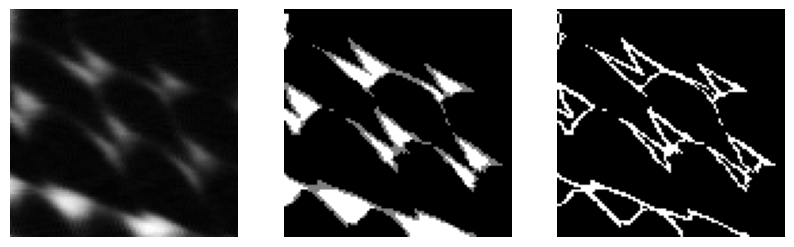

In [10]:
# シード値固定
torch_fix_seed()

# フォルダ準備
if os.path.exists(dir_output):
  shutil.rmtree(dir_output)

os.mkdir(dir_output) 

shutil.copy(load_model, dir_output)

# 分類するクラス数
classes = 3

# GPU, Optimizer, Loss function
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet_2D(classes=classes).to(device)
if torch.cuda.is_available():
    model.load_state_dict(torch.load(load_model))
else:
    model.load_state_dict(torch.load(load_model, map_location=torch.device('cpu')))

sigmoid = nn.Sigmoid()

# 入力画像を読み込み、解像度調整
img_orig = cv2.imread(input_img)
required_height = [i for i in range(img_orig.shape[0] - 15, img_orig.shape[0] + 1) if i % 16 == 0]
required_width = [i for i in range(img_orig.shape[1] - 15, img_orig.shape[1] + 1) if i % 16 == 0]
print(f"Output size: ({required_height[0]}, {required_width[0]})")
img = cv2.resize(img_orig, dsize = (required_width[0], required_height[0]))

img = img/255
img = torch.from_numpy(img.astype(np.float32)).clone()
img = img.permute(2, 0, 1)
img = img.unsqueeze(0)

output = model(img)
output = sigmoid(output)
pred = torch.argmax(output, dim=1)
pred = torch.nn.functional.one_hot(pred.long(), num_classes=classes).to(torch.float32)

orig = img[0,0,:,:].cpu().numpy()
cv2.imwrite(dir_output + "/original.png", orig*255)

pred_np = torch.argmax(pred[0,:,:,:], dim=2).cpu().numpy()
cv2.imwrite(dir_output + f"/pred.png", pred_np*255//(classes-1))
cv2.imwrite(dir_output + f"/pred_binary.png", np.where(pred_np != 0, 1, pred_np)*255)
for j in range(classes):
      if j != 0:
        pred_np = pred[0,:,:,j].cpu().numpy()
        cv2.imwrite(dir_output + f"/pred_class{j}.png", pred_np*255)

integrate_edges(
  dir_output+"/pred_class1.png",
  dir_output+"/pred_class2.png",
  dir_output+"/integrated_edge.png"
)

image_paths = [dir_output+"/original.png", dir_output+"/pred.png", dir_output+"/integrated_edge.png"]

fig, axes = plt.subplots(1, 3, figsize=(10,5))

for ax, image_path in zip(axes, image_paths):
  img = mpimg.imread(image_path)
  ax.imshow(img, cmap="gray")
  ax.axis('off')

plt.show()

### 直線パラメータ推定

In [6]:
# 対象画像の二値画像パス (ex. integrated_edge.png)
filepath = dir_output+"/integrated_edge.png"

# 出力先ディレクトリパス
output_folder = "../outputs/hough"

# rho-theta空間上で検出した直線のうち, 投票数がこれ未満/以上のものを無視する.
lower_threshold: int = 13
upper_threshold: int = 13

# (任意) 傾き正の直線検出に, 独自の閾値を使用したい場合は設定する.
lower_threshold_interdot: int = None
upper_threshold_interdot: int = None

In [7]:
hough_transform_CSD(
    method="slope_intercept",
    filepath=filepath,
    output_folder=output_folder,
    edge_extraction=False,
    thinning=False,
    lower_threshold=lower_threshold,
    upper_threshold=upper_threshold,
    lower_threshold_interdot=lower_threshold_interdot,
    upper_threshold_interdot=upper_threshold_interdot,
)

Num of Lines
|- Vertical:   94
|- Interdot:   70
|- Horizontal: 170


(output_folder)/individual_line から適切な直線を探索し、そのパラメータを line_parameters.csv から参照する。

### αファクタを算出
得られた直線パラメータからαファクタを算出する。<br>
以降、ある一組の三角形を構成する5本の直線を使用して計算を行う。

In [9]:
# TODO

### 以下、開発途中

In [8]:
# 検出した直線を確認
"""
list_linetype = ["horizontal", "interdot", "vertical"]
list_num_of_line = []
for linetype in list_linetype:
    folder_path = output_folder+"/individual_line/"+linetype
    list_file = os.listdir(folder_path)
    file_count = sum(os.path.isfile(os.path.join(folder_path, file)) for file in list_file)
    list_num_of_line.append(file_count)

current_linetype_index = 0
current_image_index = 0

# ウィジェット
button_linetype = widgets.Button(description="Change Linetype")
button_back = widgets.Button(description="Back", layout=widgets.Layout(width="50px"))
button_next = widgets.Button(description="Next", layout=widgets.Layout(width="50px"))

# イベントハンドラ
def show_output(linetype_index, image_index):
    clear_output(wait=True)
    with open(output_folder+"/individual_line/"+str(list_linetype[linetype_index])+"/"+str(image_index)+".png", "rb") as f:
        image = Image.open(io.BytesIO(f.read()))
        display(image.resize((200, 200)))
    display(widgets.VBox([widgets.HBox([button_linetype]), widgets.HBox([button_back, button_next])]))

def linetype_button_clicked(b):
    global current_linetype_index
    global current_image_index
    # 表示する直線のタイプを変更
    current_linetype_index = (current_linetype_index + 1) % 3
    # 画像を表示
    show_output(current_linetype_index, current_image_index)

def back_button_clicked(b):
    global current_linetype_index
    global current_image_index
    # 前の画像へ
    current_image_index = (current_image_index - 1) % list_num_of_line[current_linetype_index]
    # 画像を表示
    show_output(current_linetype_index, current_image_index)
    #clear_output(wait=True)
    #display(b)
    #show_image(current_linetype_index, current_image_index)

def next_button_clicked(b):
    global current_linetype_index
    global current_image_index
    # 次の画像へ
    current_image_index = (current_image_index + 1) % list_num_of_line[current_linetype_index]
    # 画像を表示
    show_output(current_linetype_index, current_image_index)


# 登録
button_back.on_click(back_button_clicked)
button_next.on_click(next_button_clicked)
button_linetype.on_click(linetype_button_clicked)

show_output(current_linetype_index, current_image_index)
"""

'\nlist_linetype = ["horizontal", "interdot", "vertical"]\nlist_num_of_line = []\nfor linetype in list_linetype:\n    folder_path = output_folder+"/individual_line/"+linetype\n    list_file = os.listdir(folder_path)\n    file_count = sum(os.path.isfile(os.path.join(folder_path, file)) for file in list_file)\n    list_num_of_line.append(file_count)\n\ncurrent_linetype_index = 0\ncurrent_image_index = 0\n\n# ウィジェット\nbutton_linetype = widgets.Button(description="Change Linetype")\nbutton_back = widgets.Button(description="Back", layout=widgets.Layout(width="50px"))\nbutton_next = widgets.Button(description="Next", layout=widgets.Layout(width="50px"))\n\n# イベントハンドラ\ndef show_output(linetype_index, image_index):\n    clear_output(wait=True)\n    with open(output_folder+"/individual_line/"+str(list_linetype[linetype_index])+"/"+str(image_index)+".png", "rb") as f:\n        image = Image.open(io.BytesIO(f.read()))\n        display(image.resize((200, 200)))\n    display(widgets.VBox([widgets.H